In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
# Excel handling
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import (
    Alignment, 
    Font, 
    PatternFill, 
    Border, 
    Side
)

# Set random seed for reproducibility
np.random.seed(42)

Load all datasets

In [3]:
# Training data
train_categorical = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_quantitative = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_connectome = pd.read_csv("widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_solutions = pd.read_excel("widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# Test data
test_categorical = pd.read_excel("widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
test_quantitative = pd.read_excel("widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_connectome = pd.read_csv("widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

print(f"Training data shapes:")
print(f"Categorical metadata: {train_categorical.shape}")
print(f"Quantitative metadata: {train_quantitative.shape}")
print(f"Functional connectomes: {train_connectome.shape}")
print(f"Target solutions: {train_solutions.shape}")


Training data shapes:
Categorical metadata: (1213, 10)
Quantitative metadata: (1213, 19)
Functional connectomes: (1213, 19901)
Target solutions: (1213, 3)


Data Exploration and Preprocessing

In [4]:
# 2.1 Merge training data
print("\nMerging training datasets...")
# Assuming participant_id is the common key
train_categorical_clean = train_categorical.set_index('participant_id')
train_quantitative_clean = train_quantitative.set_index('participant_id')
train_connectome_clean = train_connectome.set_index('participant_id')
train_solutions_clean = train_solutions.set_index('participant_id')

# Check for participant overlap and filter to common participants
common_participants = set(train_categorical_clean.index) & set(train_quantitative_clean.index) & \
                     set(train_connectome_clean.index) & set(train_solutions_clean.index)
print(f"Number of common participants across all training datasets: {len(common_participants)}")

# Filter all dataframes to include only common participants
train_categorical_clean = train_categorical_clean.loc[list(common_participants)]
train_quantitative_clean = train_quantitative_clean.loc[list(common_participants)]
train_connectome_clean = train_connectome_clean.loc[list(common_participants)]
train_solutions_clean = train_solutions_clean.loc[list(common_participants)]

# 2.2 Prepare connectome data
# Functional connectome data is likely a flattened correlation matrix
# We'll extract the upper triangular part of the matrix for each participant
# Assuming the connectome data is already in the right format (flattened correlation matrices)
print("\nProcessing connectome data...")

# 2.3 Handle missing values in metadata
print("\nHandling missing values...")
# For quantitative data, impute with median
quant_features = train_quantitative_clean.columns
quant_imputer = SimpleImputer(strategy='median')
train_quantitative_imputed = pd.DataFrame(
    quant_imputer.fit_transform(train_quantitative_clean), 
    index=train_quantitative_clean.index,
    columns=quant_features
)

# For categorical data, identify columns with missing values
cat_features = train_categorical_clean.columns
cat_na_counts = train_categorical_clean.isna().sum()
print(f"Categorical columns with missing values:")
print(cat_na_counts[cat_na_counts > 0])

# Fill categorical missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
train_categorical_imputed = pd.DataFrame(
    cat_imputer.fit_transform(train_categorical_clean),
    index=train_categorical_clean.index,
    columns=cat_features
)

# 2.4 One-hot encode categorical variables
print("\nOne-hot encoding categorical features...")
# Identify categorical columns
categorical_columns = train_categorical_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = pd.DataFrame(
    encoder.fit_transform(train_categorical_imputed[categorical_columns]),
    index=train_categorical_imputed.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Keep non-categorical columns as is
non_cat_cols = [col for col in train_categorical_imputed.columns if col not in categorical_columns]
non_cat_data = train_categorical_imputed[non_cat_cols]

# Combine encoded categorical and non-categorical data
train_categorical_encoded = pd.concat([encoded_cats, non_cat_data], axis=1)

# 2.5 Combine all features
print("\nCombining all features...")
# Merge all preprocessed features
X_train_all = pd.concat([train_categorical_encoded, train_quantitative_imputed, train_connectome_clean], axis=1)
y_train = train_solutions_clean

print(f"Final training data shape: {X_train_all.shape}")
print(f"Labels shape: {y_train.shape}")

# 2.6 Check class distribution
print("\nClass distribution for ADHD:")
print(y_train['ADHD_Outcome'].value_counts())
print("\nClass distribution for Sex:")
print(y_train['Sex_F'].value_counts())
print("\nCross-tabulation of ADHD and Sex:")
print(pd.crosstab(y_train['ADHD_Outcome'], y_train['Sex_F'], rownames=['ADHD'], colnames=['Female']))



Merging training datasets...
Number of common participants across all training datasets: 1213

Processing connectome data...

Handling missing values...
Categorical columns with missing values:
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
dtype: int64

One-hot encoding categorical features...

Combining all features...
Final training data shape: (1213, 19927)
Labels shape: (1213, 2)

Class distribution for ADHD:
ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

Class distribution for Sex:
Sex_F
0    797
1    416
Name: count, dtype: int64

Cross-tabulation of ADHD and Sex:
Female    0    1
ADHD            
0       216  166
1       581  250


3. Feature Selection

In [5]:
 #3.1 Feature importance for ADHD prediction
selector_adhd = SelectKBest(f_classif, k=100)  # Keep top 100 features
X_adhd_selected = selector_adhd.fit_transform(X_train_all, y_train['ADHD_Outcome'])
selected_indices_adhd = selector_adhd.get_support(indices=True)
selected_features_adhd = X_train_all.columns[selected_indices_adhd]

# 3.2 Feature importance for Sex prediction
selector_sex = SelectKBest(f_classif, k=100)  # Keep top 100 features
X_sex_selected = selector_sex.fit_transform(X_train_all, y_train['Sex_F'])
selected_indices_sex = selector_sex.get_support(indices=True)
selected_features_sex = X_train_all.columns[selected_indices_sex]

# 3.3 Combine features important for either task
all_selected_indices = list(set(selected_indices_adhd) | set(selected_indices_sex))
X_train_selected = X_train_all.iloc[:, all_selected_indices]
print(f"Number of selected features: {X_train_selected.shape[1]}")

Number of selected features: 197


 Modeling

In [6]:
# 4.1 Define separate evaluation functions for each target
def evaluate_adhd_model(y_true, y_pred_proba):
    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate F1 score for ADHD prediction
    return f1_score(y_true, y_pred)

def evaluate_sex_model(y_true, y_pred_proba):
    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate F1 score for Sex prediction
    return f1_score(y_true, y_pred)

# For the final weighted evaluation score (as per competition rules)
def calculate_weighted_submission_score(y_adhd_true, y_adhd_pred, y_sex_true, y_sex_pred):
    # Create binary predictions
    y_adhd_binary = (y_adhd_pred > 0.5).astype(int)
    y_sex_binary = (y_sex_pred > 0.5).astype(int)
    
    # Create DataFrame for easier manipulation
    df_eval = pd.DataFrame({
        'ADHD_true': y_adhd_true,
        'ADHD_pred': y_adhd_binary,
        'Sex_true': y_sex_true,
        'Sex_pred': y_sex_binary
    })
    
    # Calculate standard F1 scores
    f1_adhd = f1_score(df_eval['ADHD_true'], df_eval['ADHD_pred'])
    f1_sex = f1_score(df_eval['Sex_true'], df_eval['Sex_pred'])
    
    # Extract female ADHD cases for special weighting
    female_adhd = df_eval[(df_eval['ADHD_true'] == 1) & (df_eval['Sex_true'] == 1)]
    f1_female_adhd = f1_score(female_adhd['ADHD_true'], female_adhd['ADHD_pred']) if len(female_adhd) > 0 else 0
    
    # Apply the 2x weighting to female ADHD cases as per competition rules
    weighted_score = (f1_adhd + f1_sex + 2 * f1_female_adhd) / 4
    
    return weighted_score

# 4.2 Address class imbalance using SMOTE
print("\nApplying SMOTE for class balancing...")
# We need to oversample especially the female ADHD cases
# Create a combined target for SMOTE
y_combined = y_train['ADHD_Outcome'].astype(str) + '_' + y_train['Sex_F'].astype(str)
print("Distribution before SMOTE:")
print(y_combined.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_combined_resampled = smote.fit_resample(X_train_selected, y_combined)

# Convert back to separate targets
y_resampled = pd.DataFrame(index=range(len(y_combined_resampled)))
y_resampled['ADHD_Outcome'] = y_combined_resampled.str[0].astype(int)
y_resampled['Sex_F'] = y_combined_resampled.str[2].astype(int)

print("Distribution after SMOTE:")
print(pd.crosstab(y_resampled['ADHD_Outcome'], y_resampled['Sex_F'], 
                  rownames=['ADHD'], colnames=['Female']))

# 4.3 Build and train models
print("\nTraining models...")

# For ADHD prediction
adhd_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# For Sex prediction
sex_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Train the models
adhd_model.fit(X_resampled, y_resampled['ADHD_Outcome'])
sex_model.fit(X_resampled, y_resampled['Sex_F'])

# 4.4 Evaluate models with cross-validation
print("\nEvaluating models with cross-validation...")

def evaluate_model(model, X, y, cv=5, scoring='f1'):
    cv_results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f"F1 Scores: {cv_results}")
    print(f"Mean F1 Score: {cv_results.mean():.4f} (±{cv_results.std():.4f})")

print("ADHD Model Cross-Validation:")
evaluate_model(adhd_model, X_train_selected, y_train['ADHD_Outcome'])

print("\nSex Model Cross-Validation:")
evaluate_model(sex_model, X_train_selected, y_train['Sex_F'])



Applying SMOTE for class balancing...
Distribution before SMOTE:
1_0    581
1_1    250
0_0    216
0_1    166
Name: count, dtype: int64
Distribution after SMOTE:
Female    0    1
ADHD            
0       581  581
1       581  581

Training models...

Evaluating models with cross-validation...
ADHD Model Cross-Validation:
F1 Scores: [0.87209302 0.86532951 0.86705202 0.86857143 0.86956522]
Mean F1 Score: 0.8685 (±0.0023)

Sex Model Cross-Validation:
F1 Scores: [0.52941176 0.43410853 0.49230769 0.41269841 0.56551724]
Mean F1 Score: 0.4868 (±0.0571)


Threshold Optimization

In [7]:
#5.1 Define function to find optimal threshold
def find_optimal_threshold(model, X, y_true):
    y_pred_proba = model.predict_proba(X)[:, 1]
    best_threshold = 0.5
    best_f1 = 0.0
    
    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    return best_threshold

# 5.2 Find optimal thresholds for both models
# For ADHD prediction
adhd_threshold = find_optimal_threshold(adhd_model, X_train_selected, y_train['ADHD_Outcome'])

# For Sex prediction
sex_threshold = find_optimal_threshold(sex_model, X_train_selected, y_train['Sex_F'])

Optimal threshold: 0.25 (F1: 1.0000)
Optimal threshold: 0.35 (F1: 1.0000)


Feature Analysis

In [11]:
# Get feature importance scores
adhd_importance = adhd_model.feature_importances_
sex_importance = sex_model.feature_importances_

# Create feature importance DataFrames
adhd_features = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': adhd_importance
}).sort_values('Importance', ascending=False)

sex_features = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': sex_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 features for ADHD prediction:")
print(adhd_features.head(10))

print("\nTop 10 features for Sex prediction:")
print(sex_features.head(10))

# 7. Process Test Data and Generate Predictions
print("\nProcessing test data...")

# 7.1 Preprocess test data using the same pipeline as training data
test_categorical_clean = test_categorical.set_index('participant_id')
test_quantitative_clean = test_quantitative.set_index('participant_id')
test_connectome_clean = test_connectome.set_index('participant_id')

# Apply imputation to test data
test_quantitative_imputed = pd.DataFrame(
    quant_imputer.transform(test_quantitative_clean),
    index=test_quantitative_clean.index,
    columns=quant_features
)

test_categorical_imputed = pd.DataFrame(
    cat_imputer.transform(test_categorical_clean),
    index=test_categorical_clean.index,
    columns=cat_features
)

# Apply one-hot encoding to test categorical data
test_encoded_cats = pd.DataFrame(
    encoder.transform(test_categorical_imputed[categorical_columns]),
    index=test_categorical_imputed.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

test_non_cat_data = test_categorical_imputed[non_cat_cols]
test_categorical_encoded = pd.concat([test_encoded_cats, test_non_cat_data], axis=1)

# Combine all test features
X_test_all = pd.concat([test_categorical_encoded, test_quantitative_imputed, test_connectome_clean], axis=1)

# Handle any missing columns from training data
for col in X_train_all.columns:
    if col not in X_test_all.columns:
        X_test_all[col] = 0  # Add missing column with default value

# Ensure test data has the same columns as training data
X_test_all = X_test_all[X_train_all.columns]

# Select the same features as in training
X_test_selected = X_test_all.iloc[:, all_selected_indices]

# 7.2 Generate predictions
print("\nGenerating predictions...")
# Apply the optimized thresholds to generate binary predictions
adhd_probs = adhd_model.predict_proba(X_test_selected)[:, 1]
sex_probs = sex_model.predict_proba(X_test_selected)[:, 1]

adhd_preds = (adhd_probs >= adhd_threshold).astype(int)
sex_preds = (sex_probs >= sex_threshold).astype(int)

# 7.3 Create submission file
submission = pd.DataFrame({
    'participant_id': X_test_all.index,
    'ADHD_Outcome': adhd_preds,
    'Sex_F': sex_preds
})

# Save predictions
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")




Top 10 features for ADHD prediction:
                       Feature  Importance
16       SDQ_SDQ_Hyperactivity    0.050485
2      MRI_Track_Scan_Location    0.018878
0      Basic_Demos_Enroll_Year    0.016777
116       125throw_162thcolumn    0.015143
15   SDQ_SDQ_Generating_Impact    0.012103
37        104throw_166thcolumn    0.011782
91        131throw_185thcolumn    0.011259
41           0throw_58thcolumn    0.010812
89        131throw_181thcolumn    0.010538
119         70throw_91thcolumn    0.009984

Top 10 features for Sex prediction:
                  Feature  Importance
91   131throw_185thcolumn    0.035121
42    80throw_184thcolumn    0.016601
138  133throw_171thcolumn    0.016349
97   131throw_193thcolumn    0.012820
36    76throw_131thcolumn    0.012271
155   87throw_172thcolumn    0.012165
89   131throw_181thcolumn    0.011954
133   78throw_158thcolumn    0.011187
64   158throw_191thcolumn    0.010220
70    57throw_189thcolumn    0.010175

Processing test data...

Generati

Visualize some key findings

Feature importance plot saved as feature_importance.png

Number of common important features between ADHD and Sex prediction: 2
Common important features:
- 131throw_185thcolumn
- 131throw_181thcolumn


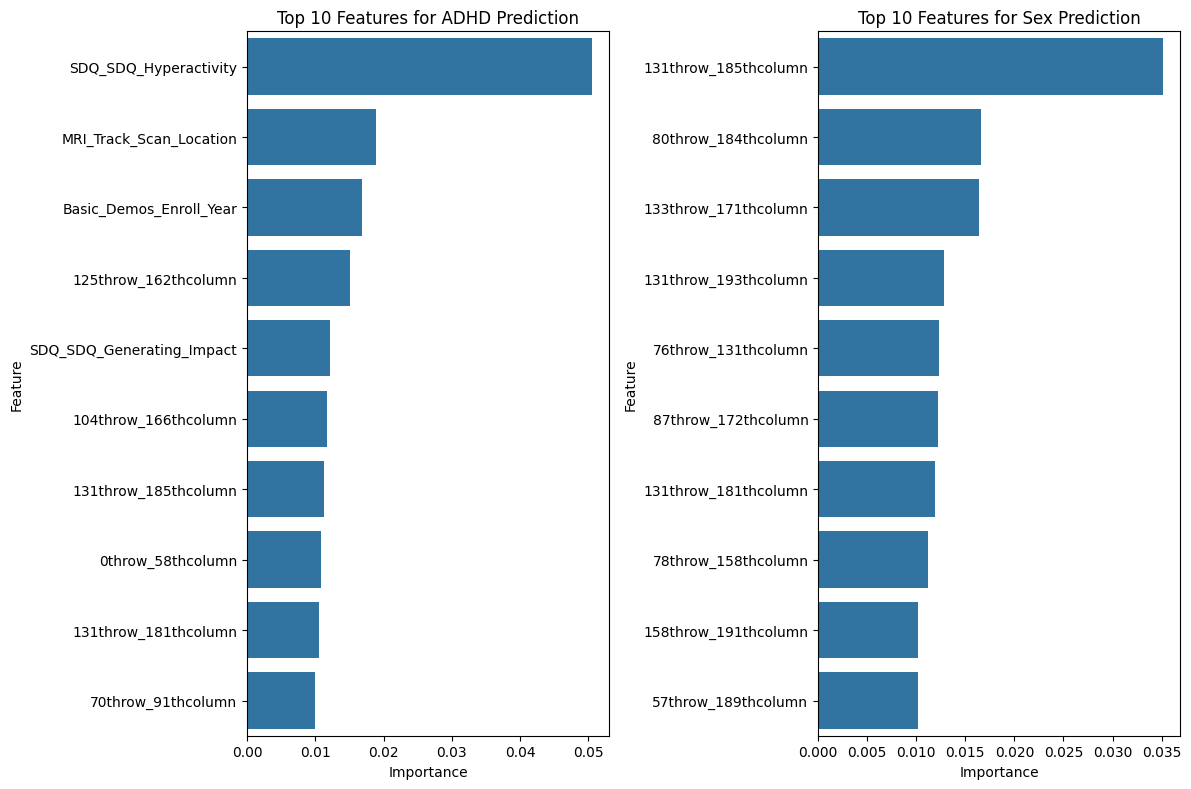

In [ ]:
#  Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=adhd_features.head(10))
plt.title('Top 10 Features for ADHD Prediction')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=sex_features.head(10))
plt.title('Top 10 Features for Sex Prediction')
plt.tight_layout()

plt.savefig('feature_importance.png')
print("Feature importance plot saved as feature_importance.png")

# 8.2 Create a heatmap showing overlapping important features
common_features = set(adhd_features['Feature'].head(20)) & set(sex_features['Feature'].head(20))
print(f"\nNumber of common important features between ADHD and Sex prediction: {len(common_features)}")
print("Common important features:")
for feature in common_features:
    print(f"- {feature}")
# 8.3 Analyze the predictions
# Plot confusion matrices if we had ground truth for validation 